# Keras Tutorial - autoencoders

Taken from here: [https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial]

In [2]:
%matplotlib inline

import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28, 28)
        return data
    
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels
    
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

(60000, 28, 28)


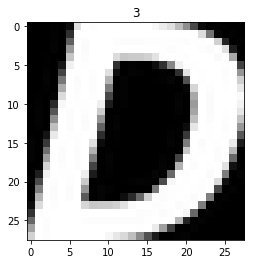

In [5]:
print(train_data.shape)

cnt = 10
plt.imshow(train_data[cnt,:,:].astype(np.uint8), cmap='gray')
plt.title(train_labels[cnt])
plt.show()

In [6]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [7]:
print(set(test_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


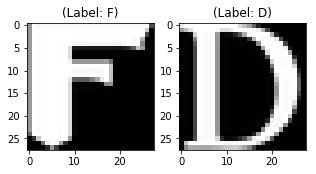

In [8]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.show()

In [9]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [11]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [12]:
# rescale the data
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

### Convolutional autoencoder

In [15]:
batch_size = 128
epochs = 30
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

autoencoder.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
con

In [17]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 6s - loss: 0.0350 - val_loss: 0.0136
Epoch 2/30
48000/48000 [==============================] - 4s - loss: 0.0101 - val_loss: 0.0072
Epoch 3/30
48000/48000 [==============================] - 4s - loss: 0.0072 - val_loss: 0.0062
Epoch 4/30
48000/48000 [==============================] - 4s - loss: 0.0058 - val_loss: 0.0045
Epoch 5/30
48000/48000 [==============================] - 4s - loss: 0.0049 - val_loss: 0.0043
Epoch 6/30
48000/48000 [==============================] - 4s - loss: 0.0043 - val_loss: 0.0035
Epoch 7/30
48000/48000 [==============================] - 4s - loss: 0.0039 - val_loss: 0.0035
Epoch 8/30
48000/48000 [==============================] - 4s - loss: 0.0036 - val_loss: 0.0035
Epoch 9/30
48000/48000 [==============================] - 4s - loss: 0.0033 - val_loss: 0.0030
Epoch 10/30
48000/48000 [==============================] - 4s - loss: 0.0031 - val_loss: 0.0029

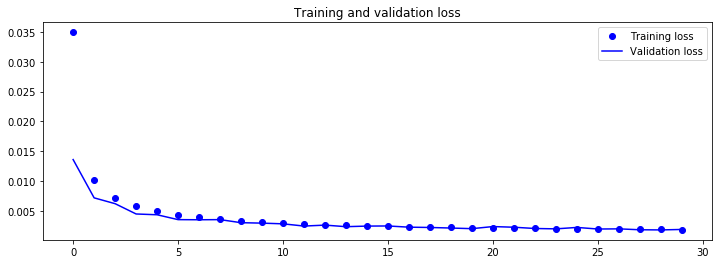

In [18]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_ = range(epochs)
plt.figure(figsize=(12,4))
plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Test Images


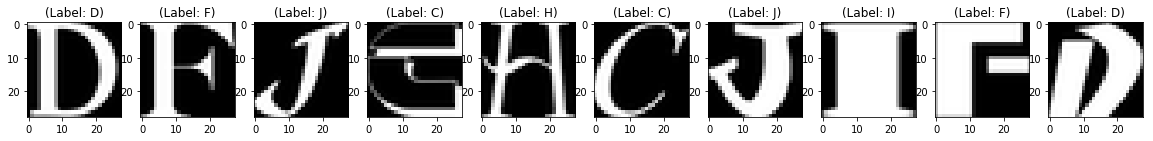

Reconstruction of Test Images


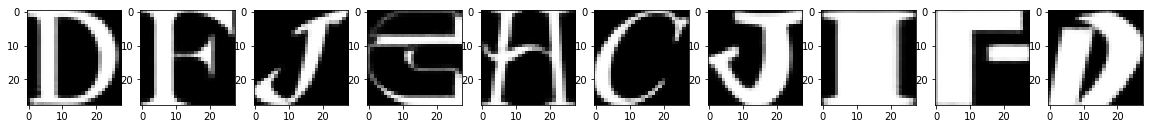

In [20]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

### Denoising autoencoder

In [21]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

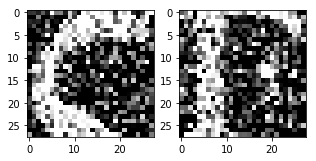

In [22]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

plt.show()

In [23]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [24]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [25]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s - loss: 0.0499 - val_loss: 0.0265
Epoch 2/20
48000/48000 [==============================] - 4s - loss: 0.0237 - val_loss: 0.0200
Epoch 3/20
48000/48000 [==============================] - 4s - loss: 0.0205 - val_loss: 0.0214
Epoch 4/20
48000/48000 [==============================] - 4s - loss: 0.0189 - val_loss: 0.0177
Epoch 5/20
48000/48000 [==============================] - 4s - loss: 0.0178 - val_loss: 0.0176
Epoch 6/20
48000/48000 [==============================] - 4s - loss: 0.0170 - val_loss: 0.0167
Epoch 7/20
48000/48000 [==============================] - 4s - loss: 0.0165 - val_loss: 0.0161
Epoch 8/20
48000/48000 [==============================] - 4s - loss: 0.0160 - val_loss: 0.0168
Epoch 9/20
48000/48000 [==============================] - 4s - loss: 0.0156 - val_loss: 0.0153
Epoch 10/20
48000/48000 [==============================] - 4s - loss: 0.0153 - val_loss: 0.0158

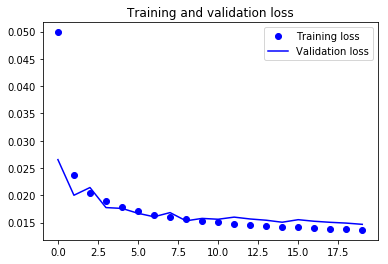

In [26]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_ = range(epochs)
plt.figure()
plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
pred = autoencoder.predict(x_test_noisy)

Test Images


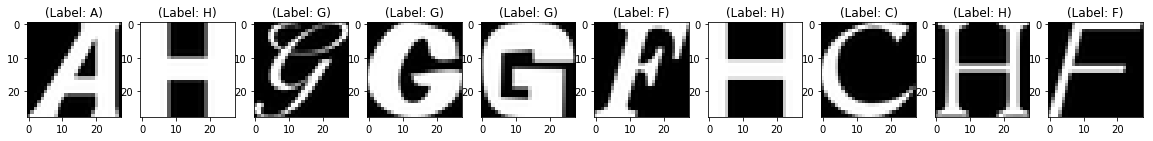

Test Images with Noise


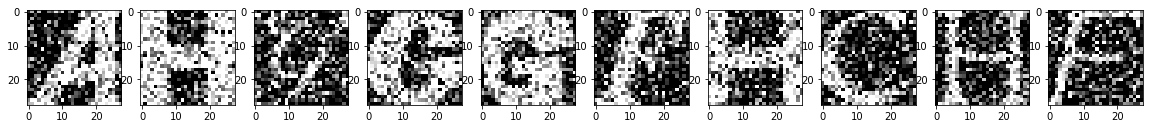

Reconstruction of Noisy Test Images


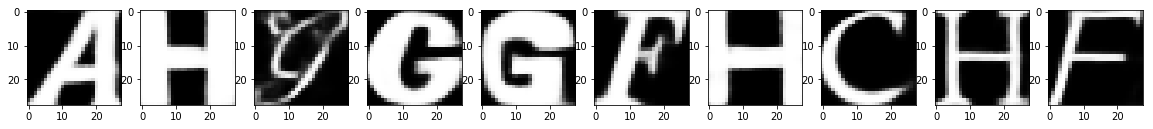

In [28]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

Test Images


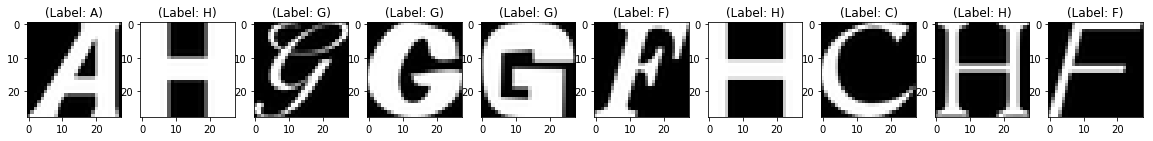

Test Images with Noise


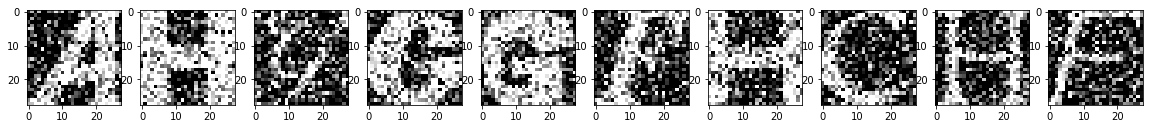

Reconstruction of Noisy Test Images


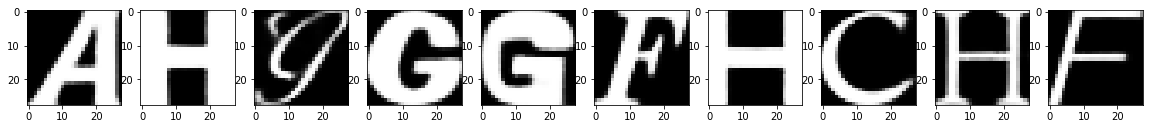

In [29]:
pred = autoencoder.predict(test_data)

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  

plt.show()


### Extracting the decoder

In [30]:
input_dec = Input(shape = (7, 7, 128))

#decoder
def decoder_arch(input_dec):
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_dec)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

decoder = Model(input_dec, decoder_arch(input_dec))
decoder.compile(loss='mean_squared_error', optimizer = RMSprop())

decoder.get_config()

{'input_layers': [['input_3', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 7, 7, 128),
    'dtype': 'float32',
    'name': 'input_3',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_3'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'filters': 128,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': 'conv2d_13',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['input_3', 0, 0, {}]]],
   'name': 'conv2d_13'}

In [31]:
for layer in decoder.layers:
    print(layer.name, '\t', layer.input_shape)
print()

for layer in autoencoder.layers:
    print(layer.name, '\t', layer.input_shape)

input_3 	 (None, 7, 7, 128)
conv2d_13 	 (None, 7, 7, 128)
up_sampling2d_5 	 (None, 7, 7, 128)
conv2d_14 	 (None, 14, 14, 128)
up_sampling2d_6 	 (None, 14, 14, 64)
conv2d_15 	 (None, 28, 28, 64)

input_2 	 (None, 28, 28, 1)
conv2d_7 	 (None, 28, 28, 1)
max_pooling2d_3 	 (None, 28, 28, 32)
conv2d_8 	 (None, 14, 14, 32)
max_pooling2d_4 	 (None, 14, 14, 64)
conv2d_9 	 (None, 7, 7, 64)
conv2d_10 	 (None, 7, 7, 128)
up_sampling2d_3 	 (None, 7, 7, 128)
conv2d_11 	 (None, 14, 14, 128)
up_sampling2d_4 	 (None, 14, 14, 64)
conv2d_12 	 (None, 28, 28, 64)


In [32]:
# copy the weights
for i in range(1, len(decoder.layers)):
    decoder.layers[i].set_weights(autoencoder.layers[i+5].get_weights())

Test Images


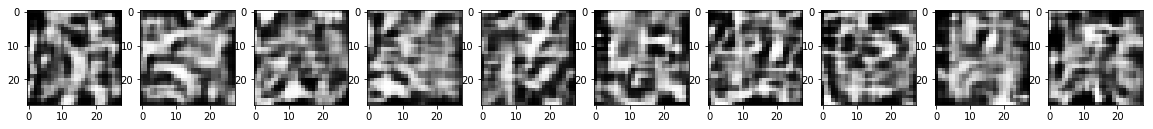

Real Images


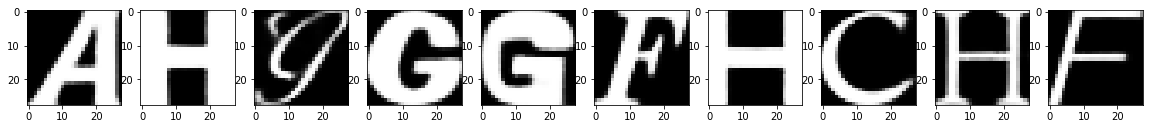

In [33]:
# get some intermediate numbers from the autoencoder
interm = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv2d_9').output)
z_real = interm.predict(test_data[10:20, :, :, :])
#z_real

# generate some noise and see the results
z = np.random.normal(loc=0.0, scale=1.0, size=(10, 7, 7, 128))
z = np.clip(z, z_real.min(), z_real.max())

pred = decoder.predict(z)
pred_real = decoder.predict(z_real)

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(z.shape[0]):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')
plt.show()


plt.figure(figsize=(20, 4))
print("Real Images")
for i in range(z.shape[0]):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred_real[i, ..., 0], cmap='gray')
plt.show()

### Clustering of the embeddings

PCA does not really work here - good only for giving a suggestions that there is some clutering.

In [34]:
allz = interm.predict(train_data)

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
projz = pca.fit_transform(np.reshape(allz, (60000, 7*7*128)))

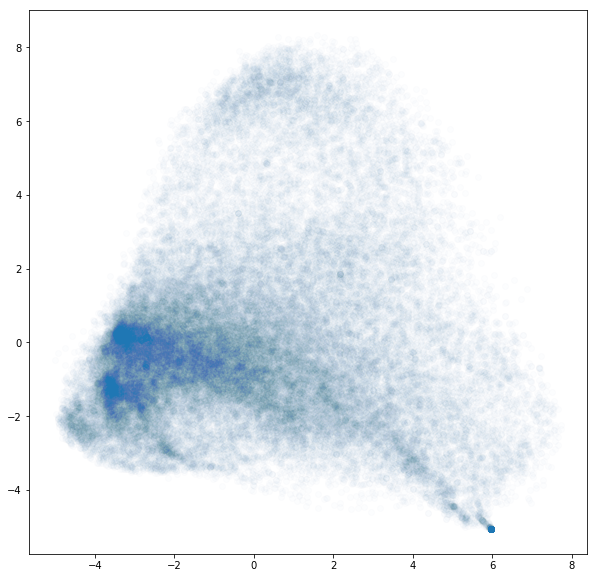

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(projz[:,0], projz[:,1], alpha=0.01)
plt.show()

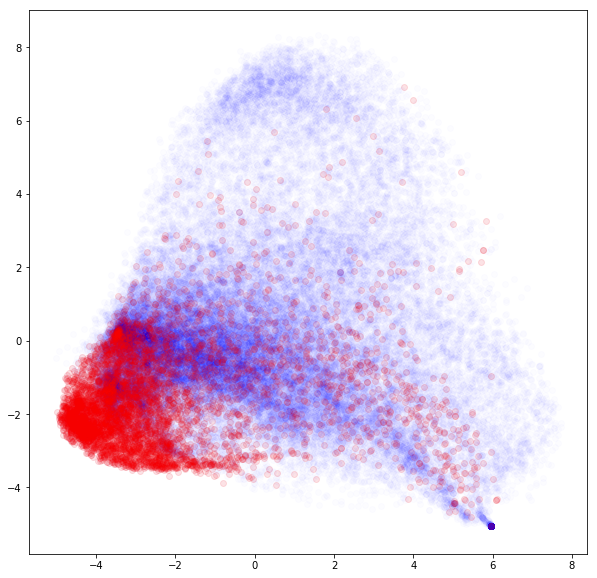

In [37]:
index = train_labels==0
dummy = projz[index, :]

plt.figure(figsize=(10,10))
plt.scatter(projz[:,0], projz[:,1], alpha=0.01, color='blue')
plt.scatter(dummy[:,0], dummy[:,1], alpha=0.1, color='red')
plt.show()